In [1]:
import pandas as pd
import numpy as np
import warnings
import requests
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt 
import warnings
from lifelines.statistics import logrank_test
from itertools import combinations
import seaborn as sns
from lifelines import CoxPHFitter

### Settings (Edit Each Run)

In [2]:
# Config file of run
config = "../global_config_bash.rc"

# cancerType, cancerTypeDetailed, or oncotreeLevel2
analysis_type = 'oncotreeLevel2'

# matplotlib colors. For ecDNA - amp -, ecDNA - amp +, and ecDNA +. First one is also a general color, we recommend keeping defaults
colors = ["steelblue", "sandybrown", "coral"]

use_facets_cn = True

### Get files from config

In [3]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [4]:
## Fill in dataframes and get CDSI info ##

# follow up timeline data (from CDSI github)
timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_follow_up.txt', sep = '\t')
diagnosis = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_diagnosis.txt', sep = '\t')

# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged_ecDNA_results_filtered_p_ecDNA.tsv', sep = '\t')
# FileA in the manifest directory
manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')

if use_facets_cn :
    facets = pd.read_csv(paths['mergedOutputDirectory'] + '/merged_facets_filtered_p_ecDNA_impactGene_annotated.tsv', sep = '\t')

### Clean Up and Prepare Dataframes

In [5]:
## Set up oncotree info from oncotree API ##

url = 'https://oncotree.mskcc.org/api/tumorTypes/tree'
headers = {'Accept': 'application/json'}

response = requests.get(url, headers=headers)

# Gets tree into dict data structure
def parse_tree(data):
    if not isinstance(data, dict):
        return data
    
    parsed_data = {}
    for key, value in data.items():
        if isinstance(value, dict):
            parsed_data[key] = parse_tree(value)
        elif isinstance(value, list):
            parsed_data[key] = [parse_tree(item) for item in value]
        else:
            parsed_data[key] = value
    
    return parsed_data

parsed_data = parse_tree(response.json())

# Matches oncotree code to cancer type
oncotree_dict = {}

def dfs_oncotree(node):
    codes = [node['code']]
    # Recursively traverse children
    for child in node['children'] :
        codes.extend(dfs_oncotree(node['children'][child]))
    return codes

for tissue in parsed_data['TISSUE']['children'] :
    for specific in parsed_data['TISSUE']['children'][tissue]['children'] :
        oncotree_dict[parsed_data['TISSUE']['children'][tissue]['children'][specific]['name']] = set(dfs_oncotree(parsed_data['TISSUE']['children'][tissue]['children'][specific]))


In [6]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'gene', 'ecDNA_prob', 'ecDNA_status']]

manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'osStatus', 'oncotreeCode']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

# Get oncotree codes
echo['oncotreeLevel2'] = ""
for i, row in echo.iterrows() :
    for key in oncotree_dict :
        if row['oncotreeCode'] in oncotree_dict[key] :
            echo.loc[i, 'oncotreeLevel2'] = key
        

In [7]:
if use_facets_cn :
    facets = facets[facets['tcn'].notna()]
    echo['facets_cn'] = np.nan

    facets_dict = {}
    for i, row in facets.iterrows() :
        facets_dict[row['sample_id'] + '_' + row['gene']] = row['tcn']
    for i, row in echo.iterrows() :
        if row['tumorSampleId'] + '_' + row['gene'] in facets_dict :
            echo.loc[i, 'facets_cn'] = facets_dict[row['tumorSampleId'] + '_' + row['gene']]

In [8]:
## Get timeline data into dicts ##

# Times of diagnosis
diagnosis_dict = {}
# Times of last contact
last_contact_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']

for i, row in diagnosis.iterrows() :
    if row['PATIENT_ID'] in diagnosis_dict :
        diagnosis_dict[row['PATIENT_ID']] = min(diagnosis_dict[row['PATIENT_ID']], row['START_DATE'])
    else :
        diagnosis_dict[row['PATIENT_ID']] = row['START_DATE']


In [9]:
## Get ECHO information into dicts ##

# ecDNA status of each patient (ecDNA presence in any gene)
ecDNAStatus_dict = {}

# ECHO amplification status
ampStatus_dict = {}
# cancer type per patient (latest)
ctype_dict = {}
# Whether the patient is alive or dead
living_dict = {}
death_dict = {}

for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        ampStatus_dict[row['patientId']] = True
        ecDNAStatus_dict[row['patientId']] = True
    elif row['ecDNA_status'] == 'non-ecDNA' :
        ampStatus_dict[row['patientId']] = True
    ctype_dict[row['patientId']] = row[analysis_type]
    if row['osStatus'] == 'LIVING' :
        living_dict[row['patientId']] = True
    if row['osStatus'] == 'DECEASED' :
        death_dict[row['patientId']] = True

if use_facets_cn :
    echo['ecDNA'] = False
    ampStatus_dict = {}
    for i, row in echo.iterrows() :
        if row['facets_cn'] > 3 :
            ampStatus_dict[row['patientId']] = True
        

In [10]:
## Fill in larger dataframe with this info ##

for_km = pd.DataFrame(echo['patientId'].unique(), columns = ['patientId'])
for_km['ecDNAStatus'] = False
for_km['facetscn>3'] = False
for_km['time'] = np.nan
for_km['osStatusInt'] = np.nan
for_km[analysis_type] = "na"
for_km['combinedStatus'] = "na"

for i, row in for_km.iterrows() :
    p_id = row['patientId']
    if p_id in ecDNAStatus_dict :
        for_km.loc[i, 'ecDNAStatus'] = True
    if use_facets_cn :
        if p_id in ampStatus_dict :
            for_km.loc[i, 'facetscn>3'] = True
    if p_id in last_contact_dict and p_id in diagnosis_dict :
        for_km.loc[i, 'time'] = last_contact_dict[p_id] - diagnosis_dict[p_id]
    if p_id in death_dict :
        for_km.loc[i, 'osStatusInt'] = 1
    elif p_id in living_dict :
        for_km.loc[i, 'osStatusInt'] = 0
    if p_id in ctype_dict :
        for_km.loc[i, analysis_type] = ctype_dict[p_id]

if use_facets_cn :
    for i, row in for_km.iterrows() :
        if row['ecDNAStatus'] and row["facetscn>3"] :
            for_km.loc[i, 'combinedStatus'] = "ecDNA & Amp"
        elif not row['ecDNAStatus'] and row['facetscn>3'] :
            for_km.loc[i, 'combinedStatus'] = "No ecDNA & Amp"
        elif not row['ecDNAStatus'] and not row['facetscn>3'] :
            for_km.loc[i, 'combinedStatus'] = "No ecDNA & No Amp"
        elif row['ecDNAStatus'] and not row["facetscn>3"] :
            for_km.loc[i, 'combinedStatus'] = "ecDNA & No Amp"

# Version without missing data in key values
for_km_nona = for_km.dropna(subset = ['time', 'osStatusInt'])
for_km_nona = for_km_nona[for_km_nona[analysis_type] != 'na']

### Overal OS KM Curves

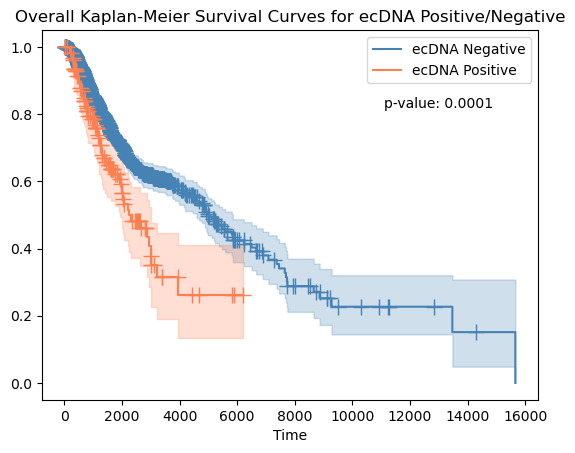

In [11]:
## Overall Survival for just ecDNA + or - ##

# Ignore all warnings
warnings.filterwarnings('ignore')

kmf = KaplanMeierFitter()
for status in for_km_nona['ecDNAStatus'].unique():
    subset = for_km_nona[for_km_nona['ecDNAStatus'] == status]
    kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
    # labels
    if status == True :
        status = "ecDNA Positive"
        color = colors[2]
    else :
        status = "ecDNA Negative"
        color = colors[0]
    kmf.plot(show_censors=True, ci_show=True, label=f'{status}', color = color)

# get p-value
results = logrank_test(for_km_nona[for_km_nona['ecDNAStatus'] == True]['time'], 
                           for_km_nona[for_km_nona['ecDNAStatus'] == False]['time'],
                           event_observed_A=for_km_nona[for_km_nona['ecDNAStatus'] == True]['osStatusInt'], 
                           event_observed_B=for_km_nona[for_km_nona['ecDNAStatus'] == False]['osStatusInt'])
plt.text(0.8, 0.8, f'p-value: {results.p_value:.4f}', horizontalalignment='center', 
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA Positive/Negative')
plt.xlabel("Time")
plt.legend()

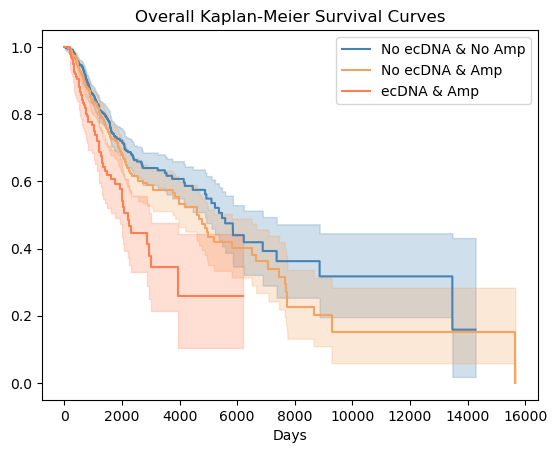

In [12]:
## Overall Survival KM Curves for ecDNA +/- and Amp +/- ##

# Ignore all warnings
warnings.filterwarnings('ignore')

if use_facets_cn :
    kmf = KaplanMeierFitter()
    for i, status in enumerate(['No ecDNA & No Amp', 'No ecDNA & Amp', 'ecDNA & Amp']):
        subset = for_km_nona[for_km_nona['combinedStatus'] == status]
        kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
        kmf.plot(show_censors=False, ci_show=True, label=f'{status}', color = colors[i])
    
    # # Add labels and legend
    plt.title('Overall Kaplan-Meier Survival Curves')
    plt.xlabel("Days")
    plt.legend()


In [13]:
## Make a p-value matrix for curve differences ##

if use_facets_cn : 
    kmf = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    
    # All different statuses
    statuses = for_km_nona['combinedStatus'].unique()
    pairwise_tests = {}
    
    for group1, group2 in combinations(statuses, 2) :
        group1_data = for_km_nona[for_km_nona['combinedStatus'] == group1]
        group2_data = for_km_nona[for_km_nona['combinedStatus'] == group2]
    
        # Fit KM curves
        kmf.fit(group1_data['time'], event_observed=(group1_data['osStatusInt'] == 1))
        kmf2.fit(group2_data['time'], event_observed=(group2_data['osStatusInt'] == 1))
        
        # Perform log-rank test
        result = logrank_test(group1_data['time'], group2_data['time'], event_observed_A=(group1_data['osStatusInt'] == 1), event_observed_B=(group2_data['osStatusInt'] == 1))
        
        # Store p-value in dictionary
        pairwise_tests[(group1, group2)] = result.p_value
    
    p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
    for (group1, group2), p_value in pairwise_tests.items():
        if group1 != group2:
            p_values_matrix.loc[group1, group2] = p_value
    p_values_matrix = p_values_matrix.fillna("")
    
    print("P-values for KM Curves")
    
    styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
        'selector': 'th',
        'props': [('border', '1px solid black')]
    }, {
        'selector': 'td',
        'props': [('border', '1px solid black')]
    }])
    styled_matrix

P-values for KM Curves


,ecDNA & Amp,No ecDNA & Amp,ecDNA & No Amp
No ecDNA & No Amp,0.000006,0.093651,0.908421
ecDNA & Amp,,0.000838,0.152604
No ecDNA & Amp,,,0.836667


### Cancer Type Level

In [14]:
## Get valid cancer types (min 10 samples ##

cancer_types_count = {}
for key, value in ctype_dict.items() :
    if value not in cancer_types_count :
        cancer_types_count[value] = 1
    else :
        cancer_types_count[value] += 1

cancer_types_to_use = []
for key, value in cancer_types_count.items() :
    if isinstance(key, str) :
        if value >= 10 :
            cancer_types_to_use.append(key)

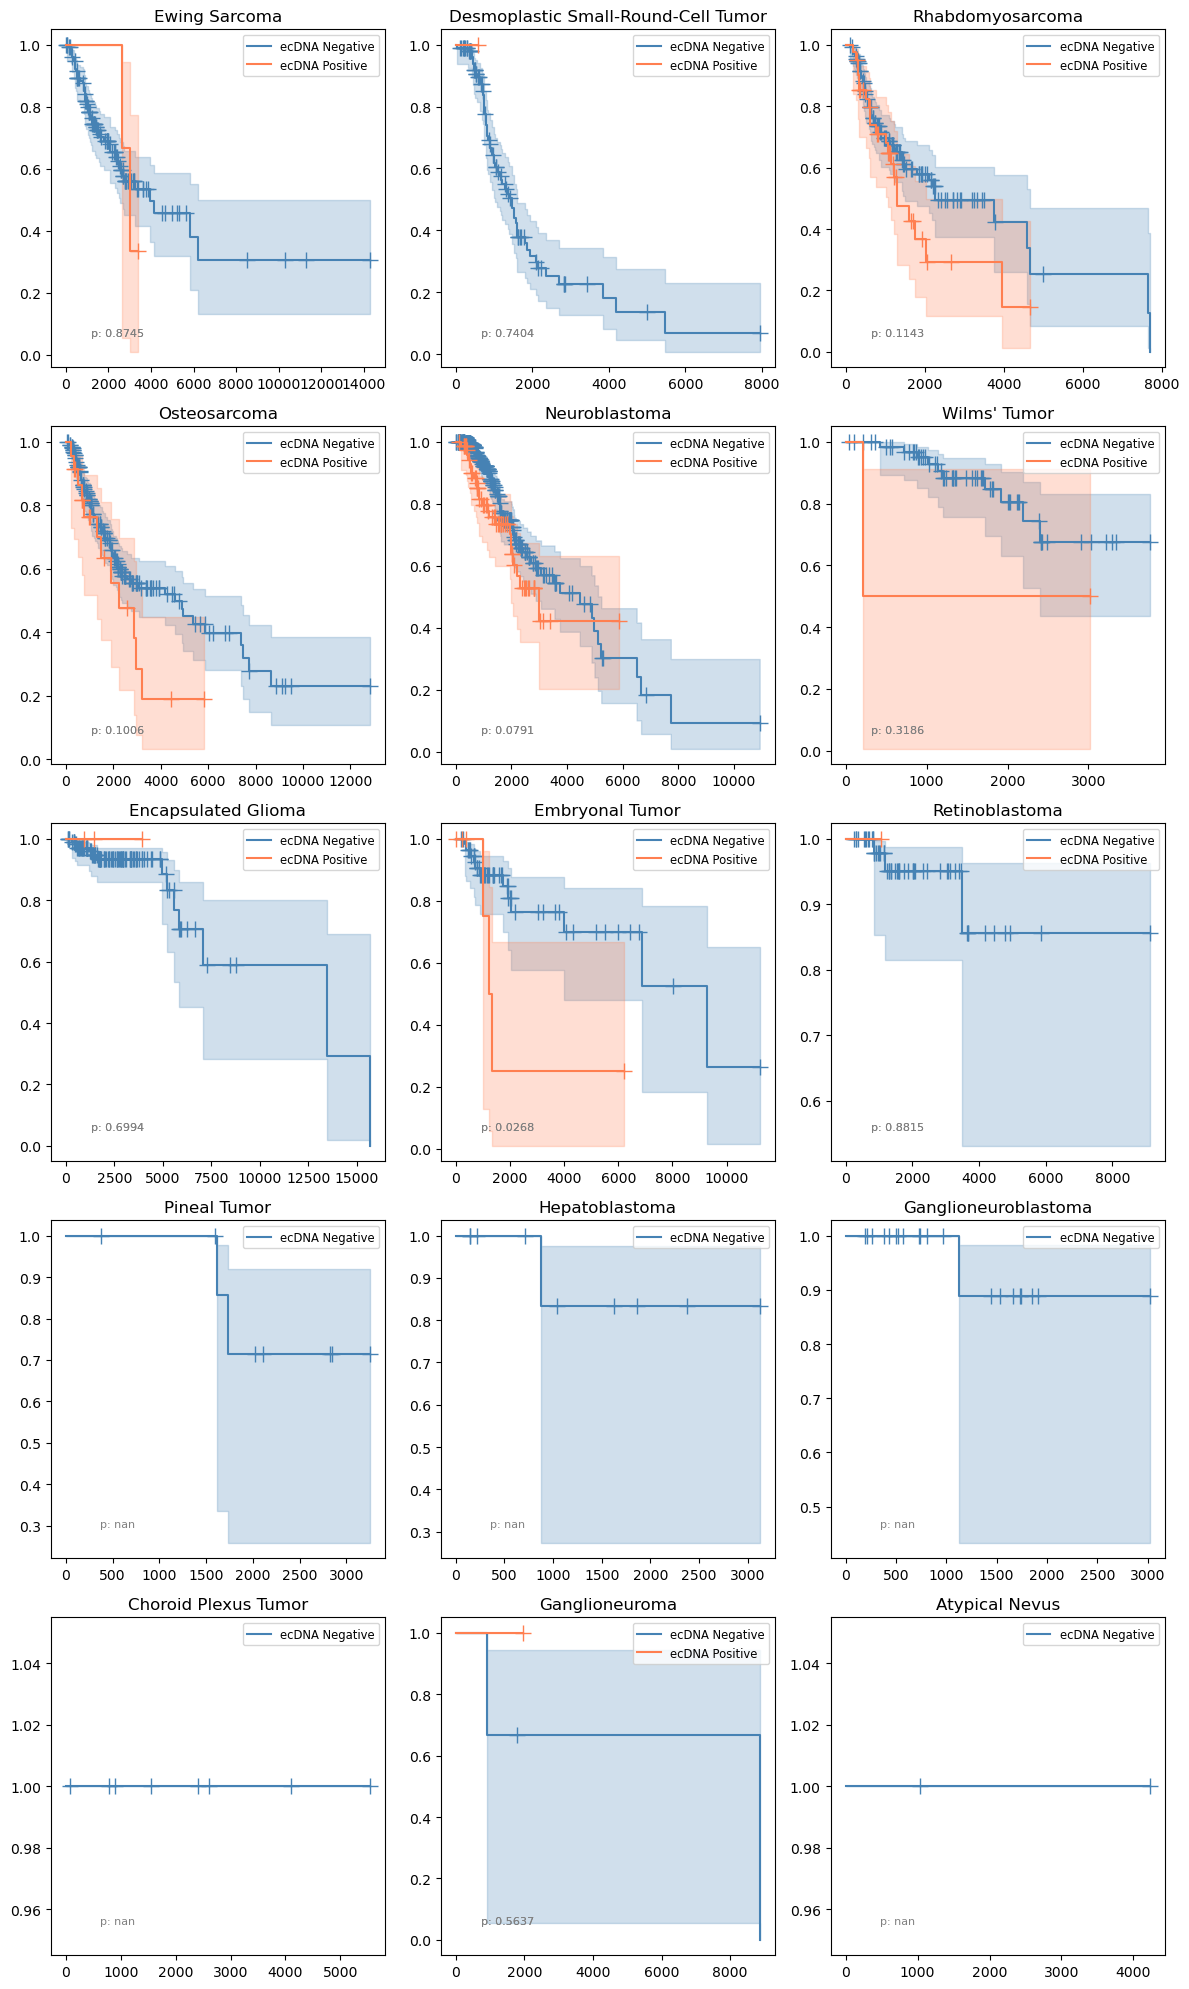

In [15]:
## ecDNA +/- curves for all individual cancer types ##

# Ignore all warnings
warnings.filterwarnings('ignore')

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types_to_use)+2)//3, 3, figsize = (12, 2 + 1.2 * len(cancer_types_to_use)))
axs = axs.flatten()
for i in range(len(cancer_types_to_use)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = for_km_nona[for_km_nona[analysis_type] == cancer_types_to_use[i]]

    for status in sorted(ecDNA_patient_specific['ecDNAStatus'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == status]
        kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
        # labels
        if status == True :
            status = "ecDNA Positive"
            color = colors[2]
        else :
            status = "ecDNA Negative"
            color = colors[0]
        kmf.plot(show_censors=True, ci_show=True, label=f'{status}', ax = axs[i], color = color)
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].set_title(cancer_types_to_use[i])
        axs[i].set_xlabel("")
    
        # Get p value
        try :
            results = logrank_test(ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['time'], 
                                    ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['time'],
                                    event_observed_A=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['osStatusInt'], 
                                    event_observed_B=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['osStatusInt'])
            if not results.p_value == np.nan :
                axs[i].text(0.2,0.1, f'p: {results.p_value:.4f}', horizontalalignment='center',
                    verticalalignment='center',
                    transform=axs[i].transAxes,
                    fontsize=8, 
                    color='grey')
        except :
            _ = 5
plt.tight_layout()
plt.show()

Using ECHO Amplifications


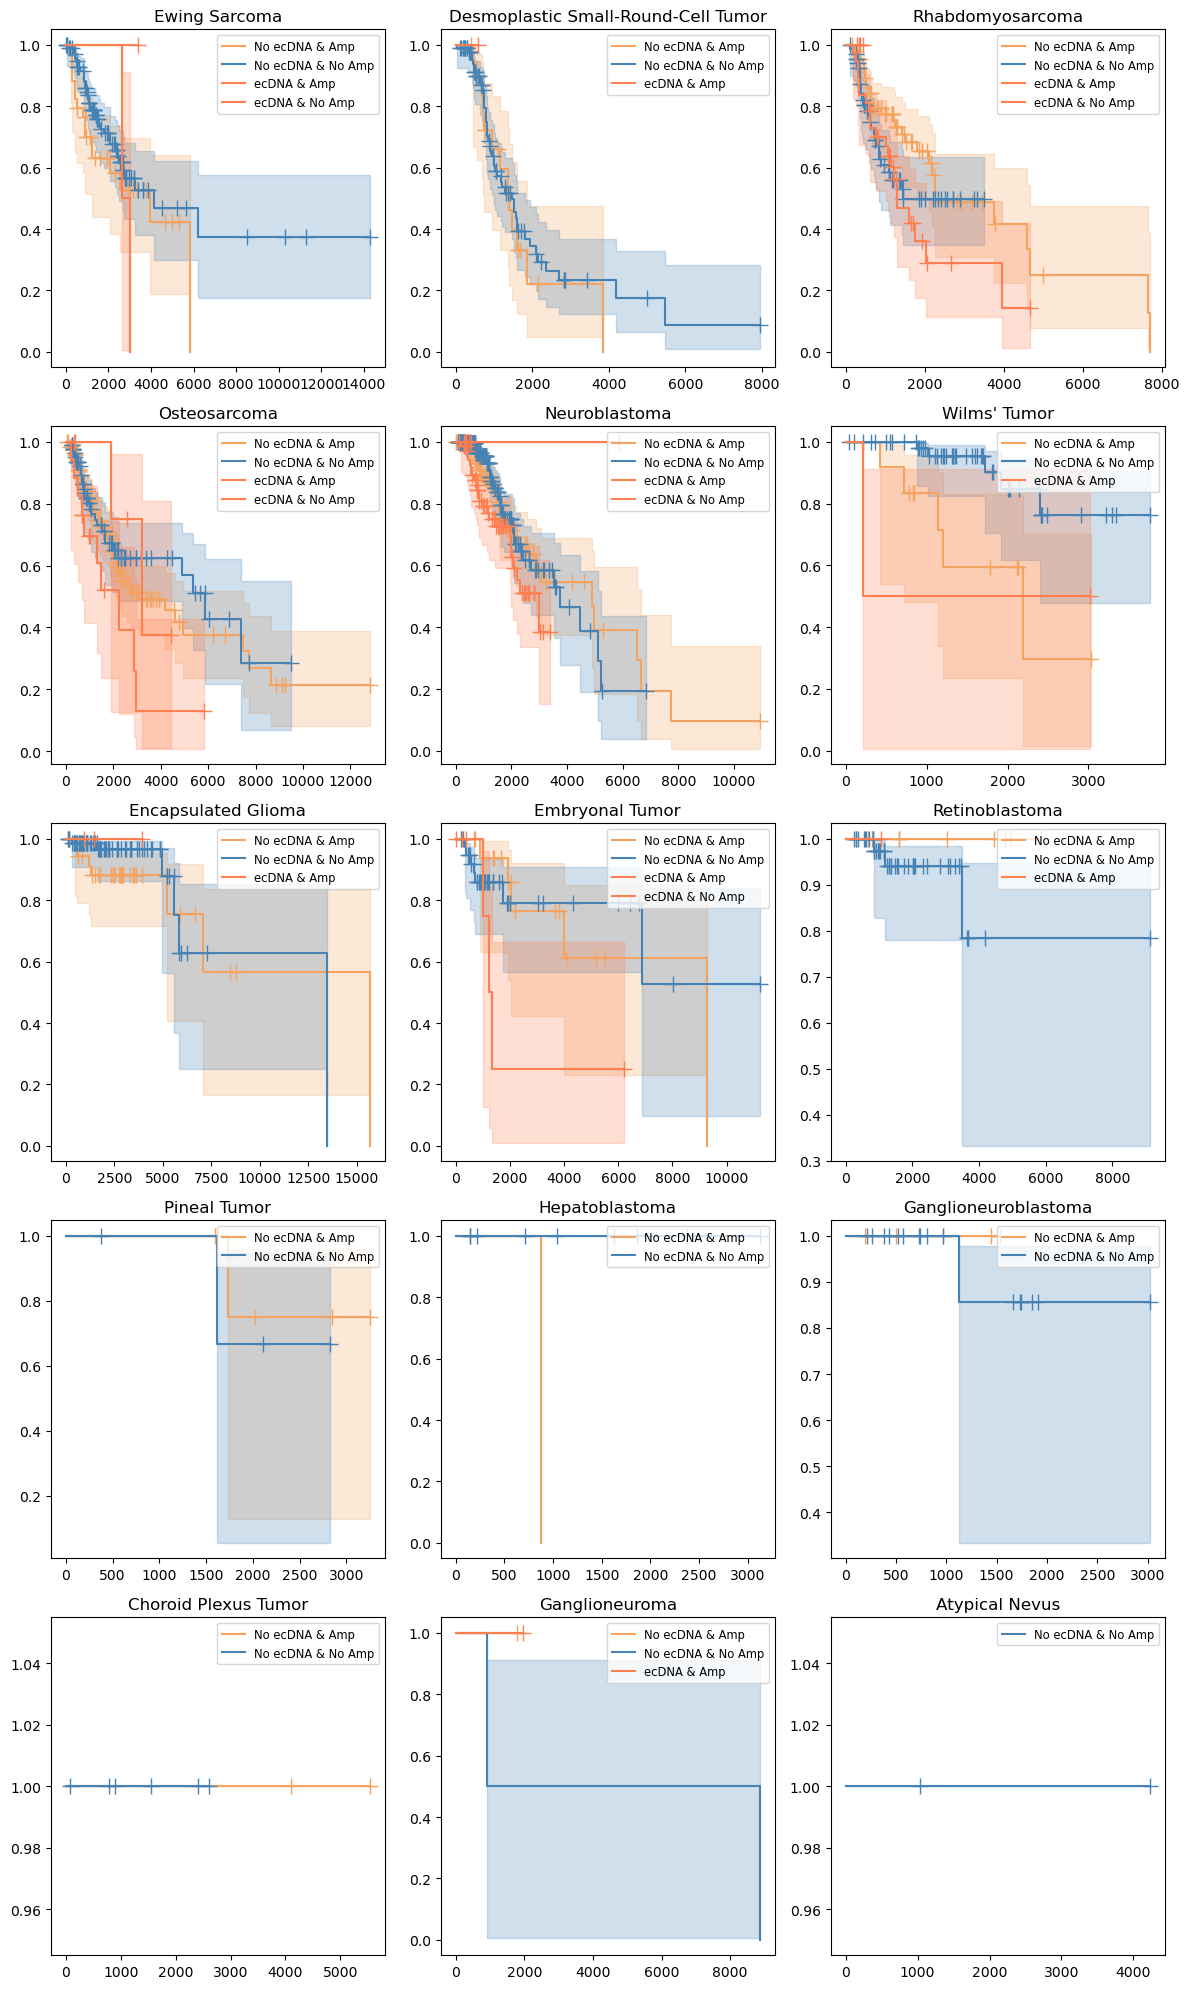

In [16]:
## Cancer type specific ecDNA Status KM Curves ##

if use_facets_cn :

    print("Using FACETS Amplifications")
    # Ignore all warnings
    warnings.filterwarnings('ignore')
    
    # Allow for multiple plots
    fig, axs = plt.subplots((len(cancer_types_to_use)+2)//3, 3, figsize = (12, 2 + 1.2 * len(cancer_types_to_use)))
    axs = axs.flatten()
    for i in range(len(cancer_types_to_use)) :
        # Get specific data set for the cancer type
        ecDNA_patient_specific = for_km_nona[for_km_nona[analysis_type] == cancer_types_to_use[i]]
    
        for status in sorted(ecDNA_patient_specific['combinedStatus'].unique()):
            if status == 'No ecDNA & No Amp' :
                color = colors[0]
            elif status == 'No ecDNA & Amp' :
                color = colors[1]
            else :
                color = colors[2]
    
            kmf = KaplanMeierFitter()
            subset = ecDNA_patient_specific[ecDNA_patient_specific['combinedStatus'] == status]
            kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
    
            kmf.plot(show_censors=True, ci_show=True, label=f'{status}', ax = axs[i], color = color)
            axs[i].legend(loc='upper right', fontsize='small')
            axs[i].set_title(cancer_types_to_use[i])
            axs[i].set_xlabel("")
    plt.tight_layout()
    plt.show()

### Cox models

In [17]:
## Make cox models and save p values and hazard ratios ##

warnings.filterwarnings("ignore")
cox_df = pd.DataFrame(columns = ['ctype', 'p_value', 'hazardRatio', 'upper', 'lower'])

# Create a dataframe for cox model output for each cancer type
for ctype in cancer_types_to_use :
    try :
        ecDNA_patient_cox_specific = for_km_nona[for_km_nona[analysis_type] == ctype]

        cox = CoxPHFitter()
        covariates = ['time', 'osStatusInt', 'ecDNAStatus']
        cox.fit(ecDNA_patient_cox_specific[covariates], duration_col = 'time', event_col = 'osStatusInt')
        new_row = {
            'ctype' : ctype,
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)'][0],
            'upper' : cox.summary['exp(coef) upper 95%'][0],
            'lower' : cox.summary['exp(coef) lower 95%'][0]
        }
        new_df = pd.DataFrame([new_row])
        cox_df = pd.concat([cox_df, new_df], ignore_index = True)

    except :
         print(f"{ctype}: Convergence Not Found")

Pineal Tumor: Convergence Not Found
Hepatoblastoma: Convergence Not Found
Ganglioneuroblastoma: Convergence Not Found
Choroid Plexus Tumor: Convergence Not Found
Atypical Nevus: Convergence Not Found


Text(0.5, 1.0, 'P-Values for Cox HR')

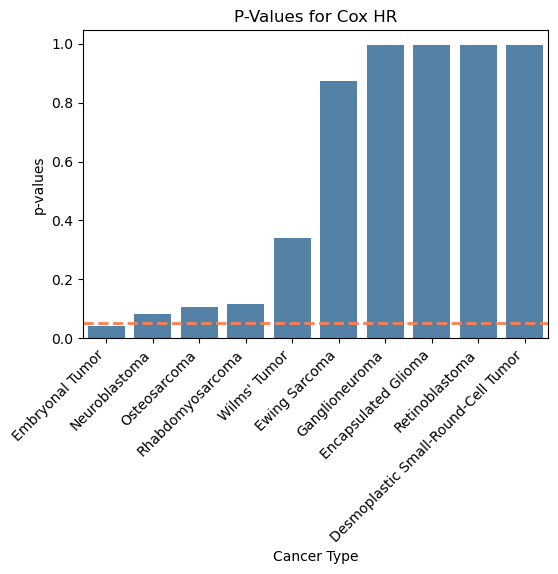

In [18]:
## Plot p-values ##

cox_df = cox_df.sort_values(by='p_value')
plt.figure(figsize=(6, 4))
bars = sns.barplot(x='ctype', y='p_value', data=cox_df, color = colors[0])
plt.xlabel('Cancer Type')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color=colors[2], linestyle='--', linewidth=2)
plt.title("P-Values for Cox HR")

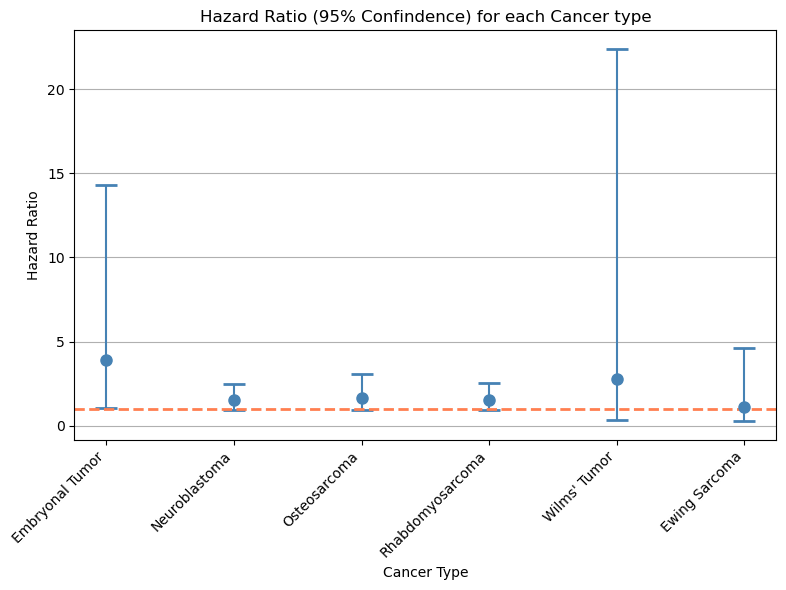

In [19]:
## Hazard ratio 95 CI Plot ##

non_zero = cox_df[cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

plt.figure(figsize=(8, 6))
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=8, capthick=2, color = colors[0])

plt.xlabel('Cancer Type')
plt.xticks(positions, non_zero['ctype'],rotation=45, ha='right')
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio (95% Confindence) for each Cancer type')
plt.axhline(y=1, color=colors[2], linestyle='--', linewidth=2)
plt.grid(True, axis='y')  
plt.tight_layout()
